In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [4]:
Path.BASE_PATH = path

In [5]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [6]:
(path/"images").ls()

(#7393) [Path('images/wheaten_terrier_107.jpg'),Path('images/saint_bernard_187.jpg'),Path('images/staffordshire_bull_terrier_46.jpg'),Path('images/wheaten_terrier_73.jpg'),Path('images/chihuahua_1.jpg'),Path('images/Persian_135.jpg'),Path('images/shiba_inu_37.jpg'),Path('images/american_pit_bull_terrier_11.jpg'),Path('images/newfoundland_138.jpg'),Path('images/american_pit_bull_terrier_111.jpg')...]

In [7]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

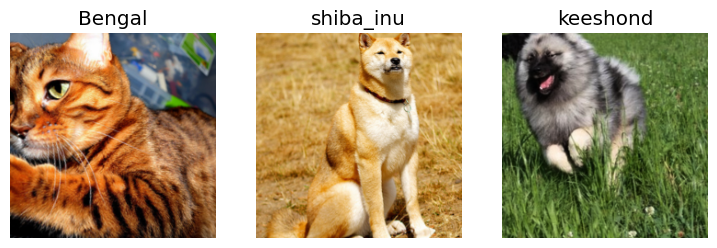

In [8]:
dls.show_batch(nrows=1, ncols=3)

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 86.9MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.536886,0.398078,0.123139,01:11


epoch,train_loss,valid_loss,error_rate,time
0,0.452571,0.290336,0.090663,01:11
1,0.369377,0.299801,0.092693,01:13
2,0.326256,0.437768,0.133965,01:10
3,0.265398,0.331939,0.090663,01:13
4,0.195530,0.363986,0.093369,01:11
5,0.140286,0.305790,0.081867,01:14
6,0.092004,0.298449,0.080514,01:11
7,0.068484,0.301493,0.075778,01:13
8,0.052357,0.285209,0.069012,01:10


epoch,train_loss,valid_loss,error_rate,time
0,0.452571,0.290336,0.090663,01:11
1,0.369377,0.299801,0.092693,01:13
2,0.326256,0.437768,0.133965,01:10
3,0.265398,0.331939,0.090663,01:13
4,0.195530,0.363986,0.093369,01:11
5,0.140286,0.305790,0.081867,01:14
6,0.092004,0.298449,0.080514,01:11
7,0.068484,0.301493,0.075778,01:13
8,0.052357,0.285209,0.069012,01:10
9,0.049755,0.283053,0.071042,01:13


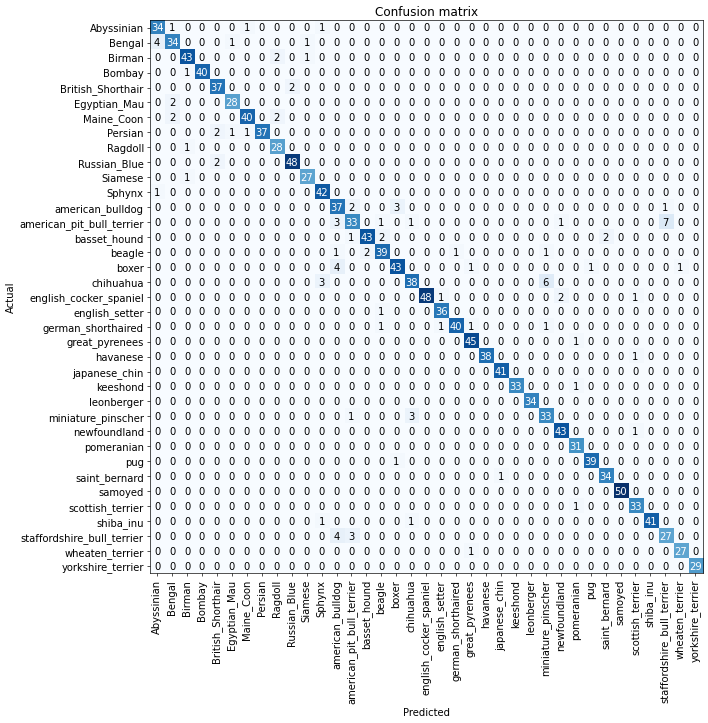

In [10]:
#width 600
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('chihuahua', 'miniature_pinscher', 6)]

/usr/local/lib/python3.10/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

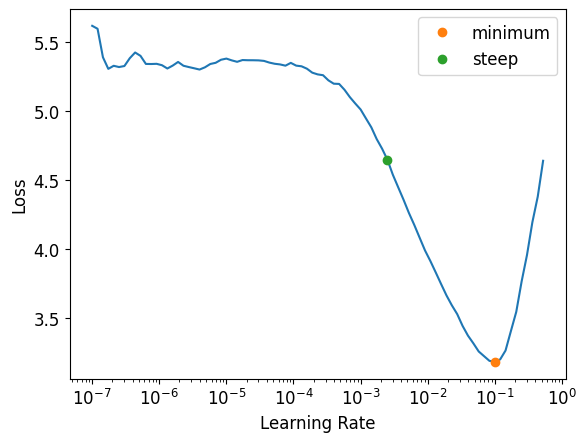

In [12]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [13]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 1.00e-02, steepest point: 2.51e-03


In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=2.51e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.386396,0.378998,0.113667,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.498556,0.367644,0.121786,01:12
1,0.298134,0.261182,0.072395,01:10


In [15]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.149991,0.367113,0.110284,01:15
1,0.516021,0.310645,0.090663,01:10
2,0.322151,0.276297,0.079838,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.264596,0.276901,0.079838,01:14
1,0.250498,0.277227,0.081867,01:11
2,0.242633,0.279670,0.080514,01:13
3,0.223616,0.270516,0.074425,01:11
4,0.176953,0.270066,0.075778,01:13
5,0.180052,0.264738,0.073072,01:10
6,0.143107,0.255127,0.069689,01:12
7,0.148092,0.256255,0.071042,01:11
8,0.132702,0.257884,0.073748,01:12
9,0.127423,0.257932,0.073748,01:11


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

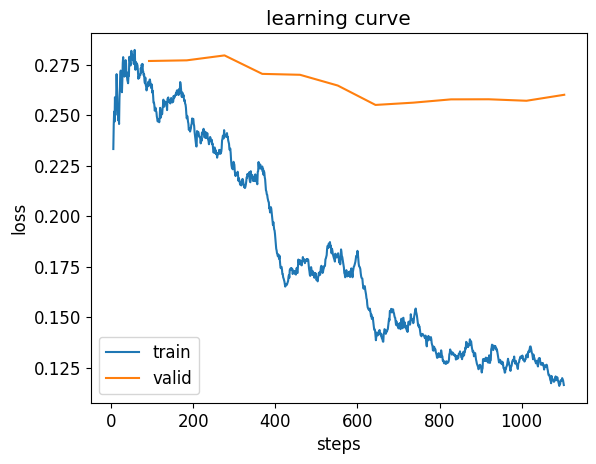

In [16]:
learn.recorder.plot_loss()

In [17]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s]
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.10/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,2.154468,0.512868,0.152233,01:08
1,0.841360,0.372742,0.116373,01:07
2,0.523886,0.339734,0.111637,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.290490,0.294535,0.090663,01:10
1,0.248949,0.313348,0.094723,01:09
2,0.194882,0.242337,0.077808,01:11
3,0.138857,0.248988,0.070365,01:09
4,0.097071,0.213374,0.066982,01:08
5,0.062562,0.217499,0.065629,01:12
